In [1]:
#Modules import
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from PIL import Image
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchvision.io import read_image
import timm
import numpy as np
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
#dictionary for tokenizer
dico_idx_to_char = {}
dico_char_to_idx = {}
file = open("target_train_data.txt", "r")
text = file.read()
update_num = 0
for element in text:
    if element not in dico_char_to_idx and element != "\n":
        dico_char_to_idx[element] = update_num
        dico_idx_to_char[update_num] = element
        update_num += 1
file.close()

dico_char_to_idx["unk"] = update_num
dico_idx_to_char[update_num] = "unk"

#find the longest charac
size_l_c = float("-inf")

with open("target_train_data.txt", 'r') as file:
   for chaine in file:
       if len(chaine) > size_l_c:
           size_l_c = len(chaine)
           l_chaine = chaine

print("the longest: ", size_l_c, l_chaine)


the longest:  10 003G3RF96



In [4]:
update_num

31

In [5]:
dico_char_to_idx

{'0': 0,
 '3': 1,
 'B': 2,
 'U': 3,
 'C': 4,
 '8': 5,
 'Y': 6,
 'G': 7,
 'R': 8,
 'F': 9,
 '9': 10,
 '6': 11,
 'J': 12,
 'T': 13,
 'S': 14,
 'I': 15,
 'N': 16,
 'P': 17,
 '4': 18,
 'K': 19,
 'D': 20,
 'V': 21,
 'A': 22,
 'M': 23,
 'O': 24,
 'X': 25,
 '5': 26,
 'E': 27,
 'H': 28,
 'W': 29,
 'L': 30,
 'unk': 31}

In [6]:
for element in list(dico_char_to_idx.keys()):
    print(element, end="")

03BUC8YGRF96JTSINP4KDVAMOX5EHWLunk

In [7]:
#Dataset building
f = open("target_train_data.txt", "r")
f_test = open("target_test_data.txt", "r")
class CustomImageDataset(Dataset):
    def __init__(self, file_for_labels, img_dir, dico_char_to_idx, dico_idx_to_char):
        self.img_labels = [label for label in file_for_labels]
        self.img_dir = img_dir
        self.dico_char_to_idx = dico_char_to_idx
        self.dico_idx_to_char = dico_idx_to_char
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        #transform to integer all character
        characters_label = self.img_labels[idx]
        label_value = [self.dico_char_to_idx[value] for value in characters_label if (value != "\n")]
        if len(label_value) <size_l_c:
            
            label_value = label_value + [dico_char_to_idx["unk"]]*(size_l_c - len(label_value))
        label_value = torch.tensor(label_value)
        #load image
        img = Image.open(f"{self.img_dir}/captcha_image_{idx}.png").convert("RGB")
        transfomr_image = transforms.Compose([transforms.Resize((224, 224)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225])])(img)
        
        #image_tensor = ToTensor()(img)
        return transfomr_image, label_value

dataset = CustomImageDataset(f, "train_ds_gen", dico_char_to_idx, dico_idx_to_char)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

dataset_test = CustomImageDataset(f_test, "test_ds_gen", dico_char_to_idx, dico_idx_to_char)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)
f.close()
f_test.close()

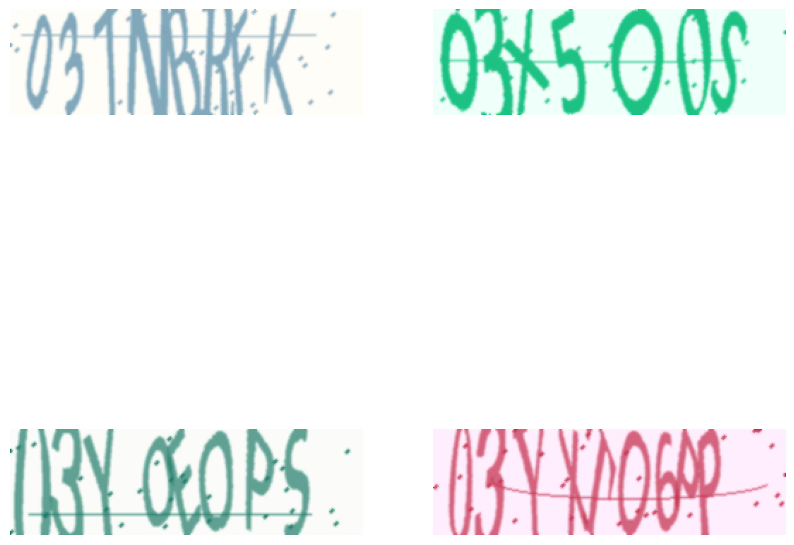

In [8]:
#plot image and label from dataset
plt.figure(figsize=(10, 10))
for i in range(4):
    image, label = dataset[i+10]
    plt.subplot(2, 2, i+1)
    plt.imshow(image.permute(1, 2, 0))
    #plt.title(dico_idx_to_char[int(element)] for element in label)
    plt.axis("off")

In [7]:
#model
class NeuralNetwork(nn.Module):
    def __init__(self, ch_1 = 70, ch_2 = 100, maxp_1 = 4, maxp_2 = 4, kernel = 3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, ch_1, kernel, padding = "same"),
            nn.LeakyReLU(),
            nn.MaxPool2d(maxp_1),
            nn.Conv2d(ch_1, ch_2, kernel, padding="same"),
            nn.LeakyReLU(),
            nn.MaxPool2d(maxp_2),
            nn.Flatten()
        )
        self.MLP_1 = nn.Sequential(
            nn.Linear(((((75)//maxp_1))//maxp_2) * ((((250)//maxp_1))//maxp_2) * ch_2, 500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100, update_num + 1),
            #nn.Softmax()
        )

        self.MLP_2 = nn.Sequential(
            nn.Linear(((((75)//maxp_1))//maxp_2) * ((((250)//maxp_1))//maxp_2) * ch_2, 500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100, update_num + 1),
            #nn.Softmax()
        )

        self.MLP_3 = nn.Sequential(
            nn.Linear(((((75)//maxp_1))//maxp_2) * ((((250)//maxp_1))//maxp_2) * ch_2, 500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100, update_num + 1),
            #nn.Softmax()
        )

        self.MLP_4 = nn.Sequential(
            nn.Linear(((((75)//maxp_1))//maxp_2) * ((((250)//maxp_1))//maxp_2) * ch_2, 500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100, update_num + 1),
            #nn.Softmax()
        )

        self.MLP_5 = nn.Sequential(
            nn.Linear(((((75)//maxp_1))//maxp_2) * ((((250)//maxp_1))//maxp_2) * ch_2, 500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100, update_num + 1),
            #nn.Softmax()
        )

        self.MLP_6 = nn.Sequential(
            nn.Linear(((((75)//maxp_1))//maxp_2) * ((((250)//maxp_1))//maxp_2) * ch_2, 500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100, update_num + 1),
            #nn.Softmax()
        )

        self.MLP_7 = nn.Sequential(
            nn.Linear(((((75)//maxp_1))//maxp_2) * ((((250)//maxp_1))//maxp_2) * ch_2, 500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100, update_num + 1),
            #nn.Softmax()
        )

        self.MLP_8 = nn.Sequential(
            nn.Linear(((((75)//maxp_1))//maxp_2) * ((((250)//maxp_1))//maxp_2) * ch_2, 500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100, update_num + 1),
            #nn.Softmax()
        )

        self.MLP_9 = nn.Sequential(
            nn.Linear(((((75)//maxp_1))//maxp_2) * ((((250)//maxp_1))//maxp_2) * ch_2, 500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100, update_num + 1),
            #nn.Softmax()
        )

        self.MLP_10 = nn.Sequential(
            nn.Linear(((((75)//maxp_1))//maxp_2) * ((((250)//maxp_1))//maxp_2) * ch_2, 500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100, update_num + 1),
            #nn.Softmax()
        )

    def forward(self, x):
        x = self.conv(x)
        output_1 = self.MLP_1(x)
        output_2 = self.MLP_2(x)
        output_3 = self.MLP_3(x)
        output_4 = self.MLP_4(x)
        output_5 = self.MLP_5(x)
        output_6 = self.MLP_6(x)
        output_7 = self.MLP_7(x)
        output_8 = self.MLP_8(x)
        output_9 = self.MLP_9(x)
        output_10 = self.MLP_10(x)
        return torch.stack([output_1, output_2, output_3, output_4, output_5, output_6, output_7, output_8, output_9, output_10], dim=1)

In [8]:
#model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.MLP_1 = nn.Sequential(
            nn.Linear(input_dim, 150),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(150, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, update_num + 1)
            #nn.Linear(50, 35),
            #nn.LeakyReLU(),
            #nn.Dropout(0.3),
        )

        self.MLP_2 = nn.Sequential(
            nn.Linear(input_dim, 150),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(150, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, update_num + 1)
            #nn.Linear(50, 35),
            #nn.LeakyReLU(),
            #nn.Dropout(0.3),
        )

        self.MLP_3 = nn.Sequential(
            nn.Linear(input_dim, 150),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(150, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, update_num + 1)
            #nn.Linear(50, 35),
            #nn.LeakyReLU(),
            #nn.Dropout(0.3),
        )

        self.MLP_4 = nn.Sequential(
            nn.Linear(input_dim, 150),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(150, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, update_num + 1)
            #nn.Linear(50, 35),
            #nn.LeakyReLU(),
            #nn.Dropout(0.3),
        )

        self.MLP_5 = nn.Sequential(
            nn.Linear(input_dim, 150),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(150, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, update_num + 1)
            #nn.Linear(50, 35),
            #nn.LeakyReLU(),
            #nn.Dropout(0.3),
        )

        self.MLP_6 = nn.Sequential(
            nn.Linear(input_dim, 150),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(150, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, update_num + 1)
            #nn.Linear(50, 35),
            #nn.LeakyReLU(),
            #nn.Dropout(0.3),
        )

        self.MLP_7 = nn.Sequential(
            nn.Linear(input_dim, 150),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(150, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, update_num + 1)
            #nn.Linear(50, 35),
            #nn.LeakyReLU(),
            #nn.Dropout(0.3),
        )

        self.MLP_8 = nn.Sequential(
            nn.Linear(input_dim, 150),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(150, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, update_num + 1)
            #nn.Linear(50, 35),
            #nn.LeakyReLU(),
            #nn.Dropout(0.3),
        )

        self.MLP_9 = nn.Sequential(
            nn.Linear(input_dim, 150),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(150, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, update_num + 1)
            #nn.Linear(50, 35),
            #nn.LeakyReLU(),
            #nn.Dropout(0.3),
        )

        self.MLP_10 = nn.Sequential(
            nn.Linear(input_dim, 150),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(150, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, update_num + 1)
            #nn.Linear(50, 35),
            #nn.LeakyReLU(),
            #nn.Dropout(0.3),
        )

    def forward(self, x):
        output_1 = self.MLP_1(x)
        output_2 = self.MLP_2(x)
        output_3 = self.MLP_3(x)
        output_4 = self.MLP_4(x)
        output_5 = self.MLP_5(x)
        output_6 = self.MLP_6(x)
        output_7 = self.MLP_7(x)
        output_8 = self.MLP_8(x)
        output_9 = self.MLP_9(x)
        output_10 = self.MLP_10(x)
        return torch.stack([output_1, output_2, output_3, output_4, output_5, output_6, output_7, output_8, output_9, output_10], dim=1)

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_total = 0
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred.view(-1, update_num + 1), y.view(-1))
        loss_total += loss
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * 8 + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{batch:>5d}]")
        
    print(f"loss: {loss_total/num_batches}")
    return loss_total/num_batches

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred.view(-1, update_num + 1), y.view(-1))
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    #correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

In [10]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=update_num + 1)
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [11]:
#Hyperparameters
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
#freeze weights of the model
#for param in model.parameters():
#    param.requires_grad = False
#model.fc = NeuralNetwork(512, update_num + 1)
model.head = NeuralNetwork(768, update_num + 1)
#model = NeuralNetwork().to(device)
model = model.to(device)
learning_rate = 1e-3
epochs = 100
#loss function
loss_fn = nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [12]:
table_loss = []
table_test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    table_loss.append(train_loop(dataloader, model, loss_fn, optimizer).cpu().detach().numpy())
    table_test_loss.append(test_loop(dataloader_test, model, loss_fn).cpu().detach().numpy())
print("Done!")

Epoch 1
-------------------------------
loss: 3.499485  [   64/    0]


KeyboardInterrupt: 

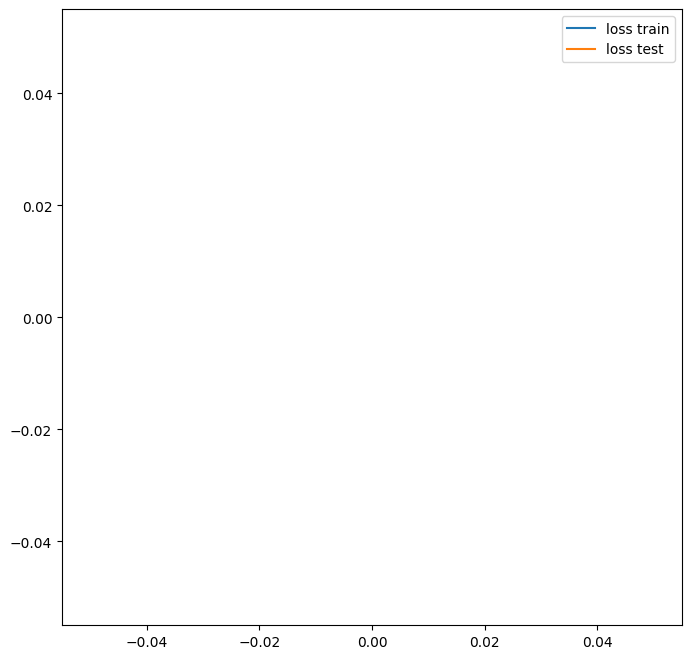

In [13]:
plt.figure(figsize=(8, 8))
plt.plot(table_loss, label = "loss train")
plt.plot(table_test_loss, label = "loss test")
plt.legend()
plt.show()

In [16]:
for i in range (600, 610):
    result = torch.max(model(dataset[i][0].reshape(1, 3, 250, 75).to(device)), dim = 2).indices.cpu().detach().numpy()[0]
    result = [dico_idx_to_char[value] for value in result]
    truth = dataset[i][1].cpu().detach().numpy()
    truth = [dico_idx_to_char[value] for value in truth]
    print("pred: ", "".join(result), "".join(truth))
    print("-----------------")

pred:  UDLT4I44unkunk 3XTLJGKKCunk
-----------------
pred:  U6CTXI4Vunkunk 3XTUGPJ8unkunk
-----------------
pred:  UOCTXI4Vunkunk 3XUJPWEunkunkunk
-----------------
pred:  56CTXI4Vunkunk 3XX00B83Eunk
-----------------
pred:  UDCYXI4Vunkunk 3Y5EC33unkunkunk
-----------------
pred:  UDLYXI4Vunkunk 3Y6SRJMK8unk
-----------------
pred:  UDCT4I44unkunk 3YAXVHFUunkunk
-----------------
pred:  J60YXI44unkunk 3YKGL04WTunk
-----------------
pred:  LSCJXI44unkunk 3YNVHVYRunkunk
-----------------
pred:  UDCTXI4Vunkunk 3YVCM9Kunkunkunk
-----------------


In [50]:
truth = dataset[610][1].cpu().detach().numpy()
truth = [dico_idx_to_char[value] for value in truth]
print("".join(truth))

3X8EHA4unkunkunk


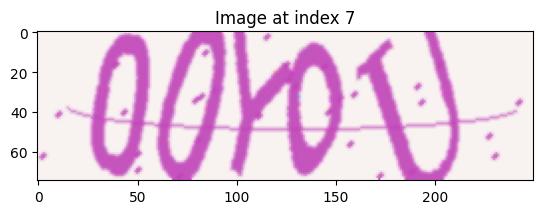

In [42]:
# Display the image from the dataset at index 7
img, _ = dataset[0]
plt.imshow(img.permute(1, 2, 0))
plt.title("Image at index 7")
plt.show()

In [74]:
result = torch.max(model(dataset_test[2][0].reshape(1, 3, 75, 250).to(device)), dim = 2)
result = [dico_idx_to_char[value] for value in result.indices.cpu().detach().numpy()[0]]
print("".join(result))

X568R6Runkunkunk


In [78]:
truth = dataset_test[2][1]
truth = [dico_idx_to_char[value] for value in truth.cpu().detach().numpy()]
print("".join(truth))


N6X8EAC4unkunk


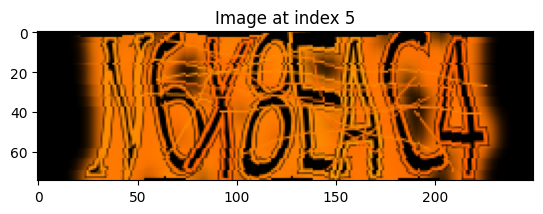

In [79]:
# Display the image from the dataset at index 
img, _ = dataset_test[2]
plt.imshow(img.permute(1, 2, 0))
plt.title("Image at index 5")
plt.show()
